# Bibliotecas

In [ ]:
import matplotlib as mpl
from pylab import cm
from scipy.integrate import odeint

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from scipy.optimize import curve_fit
from scipy.optimize import fsolve

# Funções Auxiliares

In [2]:
def read_file(file_path, columns = 5):
    with open(file_path, 'r') as file:
        dados = file.readlines()

    cor1_x  = list()
    cor1_y  = list()

    cor2_x  = list()
    cor2_y  = list()

    tempo   = list()

    for linha in dados[2:]:
        var      = linha.split()
        
        if len(var) == columns:
            tempo   += [float(var[0].replace(',','.'))]

            cor1_x  += [float(var[1].replace(',','.'))]
            cor1_y  += [float(var[2].replace(',','.').replace('\x00', ''))]
            
            if columns > 3:
                cor2_x  += [float(var[3].replace(',','.'))]
                cor2_y  += [float(var[4].replace(',','.').replace('\x00', ''))]
    if columns > 3:
        return tempo, cor1_x, cor1_y, cor2_x, cor2_y
    return tempo, cor1_x, cor1_y

In [3]:
def fit_func(t, a, b, c):
    return a*pow(1/np.cosh(b - c*t), 2)

In [4]:
def chi_sq(obs, exp, err):
    soma = 0
    assert(len(obs) == len(exp)) #ERRO DE DIMENSÕES
    for i in range(len(obs)):
        soma += pow((obs[i] - exp[i])/err[i], 2)
    return soma

In [5]:
def get_ROI(x, y, cuts):
    
    ys = [[],[]]
    ts = [[],[]]
    
    for i in range(2):
        for j in range(len(x)):
            if (x[j] > cuts[i][0] and x[j] < cuts[i][1]):
                ts[i] += [x[j]]
                ys[i] += [y[j]]
                
    return ys[0], ys[1], ts[0], ts[1]

# Dados a ajustar

In [6]:
data = ["h6B20A2", "h6a6b10_3b", "h5p5a4b10_2b", "h5p5a2b10_2b", "h4B40A1", "h4a6b10_5b_", "h4a4b10_barreira25_5b", "h4a4b10_5b_", "h4a2b20_5b"]

In [7]:
reg_interesse = [[[0.6, 2.3], [7, 8.5]], [[0.1, 1.25], [6, 7.5]], [[0, 1.25], [6.5, 7.8]], [[0, 2], [7, 8.75]], [[1.8, 4.5], [10, 12.5]], [[0.5, 3], [8.25, 10]], [[1.4, 4.3]], [[0, 2], [7.5, 9.8]], [[0.4, 2], [8, 9.88]]]

Determinating intervalos nos quais efetuar os fits e aproximações iniciais

9.888073921


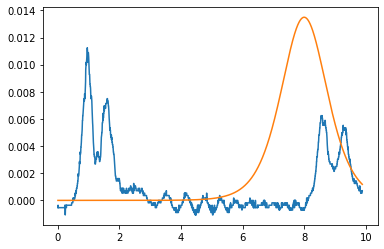

In [8]:
tempo, cor1_x, cor1_y, cor2_x, cor2_y = read_file("Dados/" + data[8] + ".txt")

print(tempo[-1])

#plt.xlim(8, 9.88)
plt.plot(tempo, cor1_y)

y = list()
for i in tempo:
    y += [fit_func(i, 0.0135, -8, -1)]

plt.plot(tempo, y)

In [9]:
one_peak = [0, 1, 2, 3] #LISTA COM OS ÍNDICES DOS DADOS COM APENAS 1 PICO
two_peak = [5, 7, 8]
tri_peak = [4]

In [10]:
p1st_aprx = [0.0135, -1, -1]
p2nd_aprx = [0.0135, -8, -1]

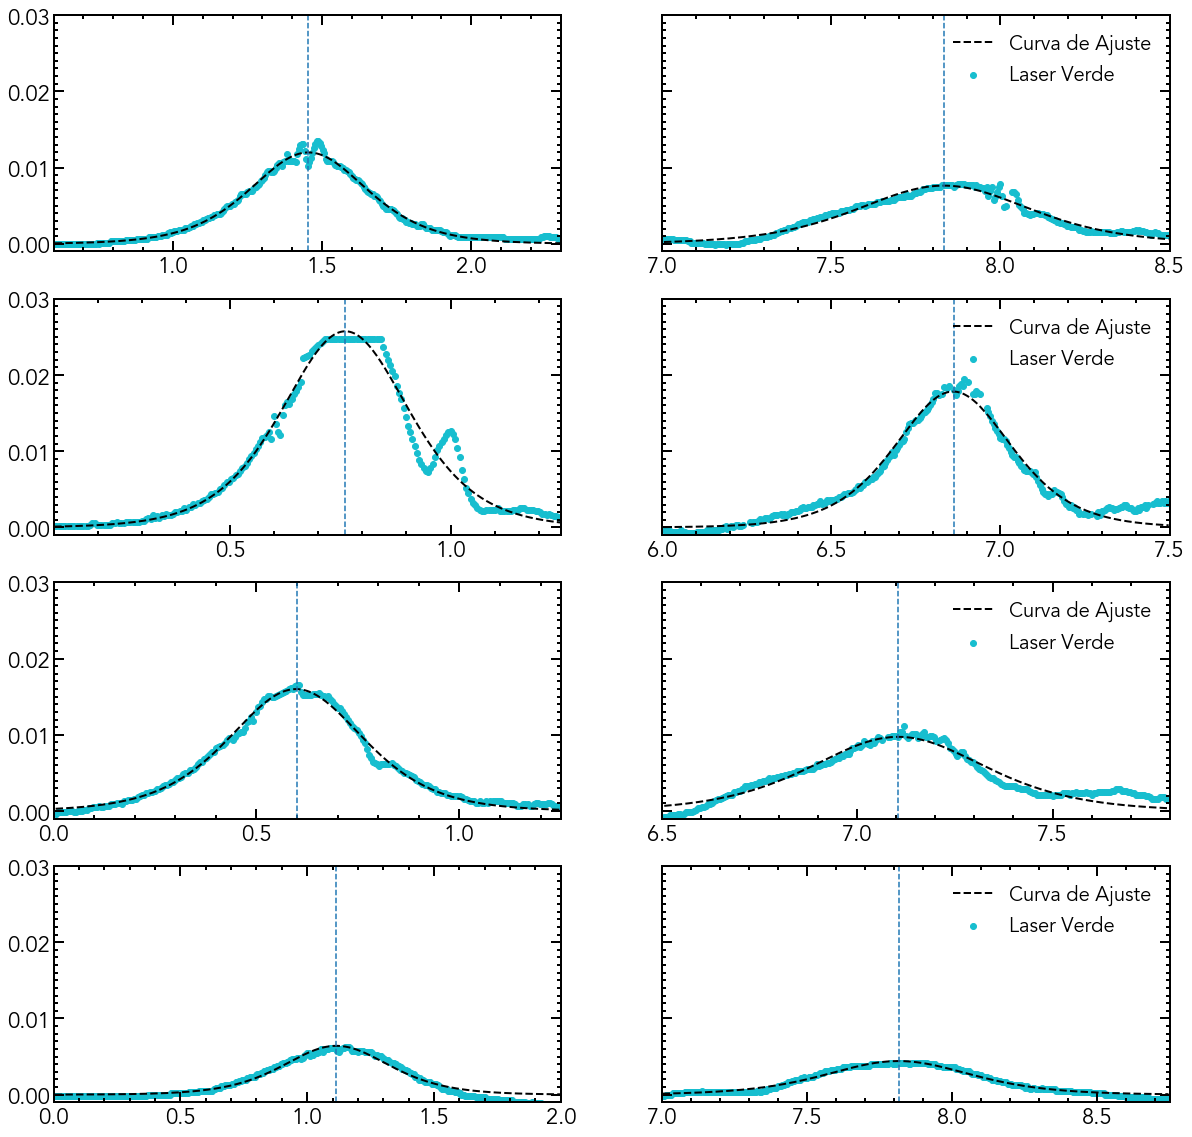

In [11]:
fig = plt.figure()
fig.set_size_inches(20, 20)

mpl.rcParams['font.family'] = 'Avenir'
plt.rcParams['font.size'] = 22
plt.rcParams['axes.linewidth'] = 2

colors = cm.get_cmap('tab10', 2)

count = 0
for i in one_peak:
    #get data
    tempo, cor1_x, cor1_y, cor2_x, cor2_y = read_file("Dados/" + data[i] + ".txt")
    #select data from ROI
    y_b, y_t, t_b, t_t = get_ROI(tempo, cor1_y, reg_interesse[i])
    
    pars, cov = curve_fit(f=fit_func, xdata=t_b, ydata=y_b, p0=p1st_aprx)
    sigmas    = np.sqrt(np.diag(cov))
    
    pars_2, cov = curve_fit(f=fit_func, xdata=t_t, ydata=y_t, p0=p2nd_aprx)
    sigmas    = np.sqrt(np.diag(cov))
    
    
    count += 1
    ax2= fig.add_subplot(len(one_peak),2,count)      # FIT DO SOLITÃO A SAIR
    count += 1
    ax3= fig.add_subplot(len(one_peak),2,count)      # FIT DO SOLITÃO A VOLTAR
    
    #----------------------------------------------------------------------------#
    #----------------------------------AX2---------------------------------------#
    #----------------------------------------------------------------------------#

    ax2.set_xlim(reg_interesse[i][0][0], reg_interesse[i][0][1])
    ax2.set_ylim(-0.001, 0.03)

    #ax2.set_yticklabels([0, 0, 0.5, 1, 1.5])

    ax2.xaxis.set_tick_params(which='major', size=10, width=2, direction='in', top='on')
    ax2.xaxis.set_tick_params(which='minor', size=4, width=2, direction='in', top='on')
    ax2.yaxis.set_tick_params(which='major', size=10, width=2, direction='in', right='on')
    ax2.yaxis.set_tick_params(which='minor', size=4, width=2, direction='in', right='on')

    ax2.xaxis.set_major_locator(mpl.ticker.MultipleLocator(0.5))
    ax2.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.1))
    ax2.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.01))
    ax2.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.001))

    ax2.scatter(t_b, y_b, lw = "1", color=colors(1), label="Laser Verde")

    #ARRANJAR FORMAMAIS EFICIENTE DE FAZER ISTO
    y = []
    for k in t_b:
        y += [fit_func(k, pars[0], pars[1], pars[2])]

    ax2.plot(t_b, y, linestyle='--', linewidth=2, color='black', label="Curva de Ajuste")
    
    dt = t_b[y.index(max(y))]
    ax2.axvline(dt, linestyle='--')

    #ax2.legend(bbox_to_anchor=(0.62, 1), loc=1, frameon=False, fontsize=17)

    #----------------------------------------------------------------------------#
    #----------------------------------AX3---------------------------------------#
    #----------------------------------------------------------------------------#
    ax3.set_xlim(reg_interesse[i][1][0], reg_interesse[i][1][1])
    ax3.set_ylim(-0.001, 0.03)

    ax3.set_yticklabels([])

    ax3.xaxis.set_tick_params(which='major', size=10, width=2, direction='in', top='on')
    ax3.xaxis.set_tick_params(which='minor', size=4, width=2, direction='in', top='on')
    ax3.yaxis.set_tick_params(which='major', size=10, width=2, direction='in', right='on')
    ax3.yaxis.set_tick_params(which='minor', size=4, width=2, direction='in', right='on')

    ax3.xaxis.set_major_locator(mpl.ticker.MultipleLocator(0.5))
    ax3.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.1))
    ax3.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.01))
    ax3.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.001))

    ax3.scatter(t_t, y_t, lw = "1", color=colors(1), label="Laser Verde")

    #ARRANJAR FORMAMAIS EFICIENTE DE FAZER ISTO
    y = []
    for k in t_t:
        y += [fit_func(k, pars_2[0], pars_2[1], pars_2[2])]

    ax3.plot(t_t, y, linestyle='--', linewidth=2, color='black', label="Curva de Ajuste")
    
    dt = t_t[y.index(max(y))]
    ax3.axvline(dt, linestyle='--')

    ax3.legend(bbox_to_anchor=(1, 1), loc=1, frameon=False, fontsize=20)